In [2]:
import os
import time
from datetime import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ivolatility as ivol

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt

from nelson_siegel_svensson.calibrate import calibrate_nss_ols

## Kou Model

In [3]:
# --- Step 1: Kou Characteristic Function ---
def kou_charfunc(phi, S0, sigma, lambd, p, eta1, eta2, tau, r):
    """
    Characteristic function for the Kou Double Exponential Jump Model.
    """
    drift = r - 0.5 * sigma**2 - lambd * (p * eta1 / (eta1 + 1) + (1 - p) * eta2 / (eta2 + 1) - 1)
    exp1 = np.exp(1j * phi * (np.log(S0) + drift * tau))
    diffusion = -0.5 * sigma**2 * phi**2 * tau
    jumps = lambd * tau * (
        p * eta1 / (eta1 - 1j * phi) + (1 - p) * eta2 / (eta2 + 1j * phi) - 1
    )
    return exp1 * np.exp(diffusion + jumps)

# --- Step 2: Integrand for Numerical Integration ---
def integrand_kou(phi, S0, sigma, lambd, p, eta1, eta2, tau, r, K):
    """
    Integrand for numerical integration in the Kou model.
    """
    args = (S0, sigma, lambd, p, eta1, eta2, tau, r)
    numerator = np.exp(r * tau) * kou_charfunc(phi - 1j, *args) - K * kou_charfunc(phi, *args)
    denominator = 1j * phi * K**(1j * phi)
    return numerator / denominator

# --- Step 3: Rectangular Numerical Integration ---
def kou_price_rec(S0, K, sigma, lambd, p, eta1, eta2, tau, r):
    """
    Option price using rectangular integration for the Kou model.
    """
    args = (S0, sigma, lambd, p, eta1, eta2, tau, r)
    P, umax, N = 0, 100, 10000
    dphi = umax / N  # dphi is width

    for i in range(1, N):
        phi = dphi * (2 * i + 1) / 2  # midpoint to calculate height
        numerator = np.exp(r * tau) * kou_charfunc(phi - 1j, *args) - K * kou_charfunc(phi, *args)
        denominator = 1j * phi * K**(1j * phi)
        P += dphi * numerator / denominator

    return np.real((S0 - K * np.exp(-r * tau)) / 2 + P / np.pi)

# --- Step 4: Option Price Using Scipy Quad Integration ---
def kou_price(S0, K, sigma, lambd, p, eta1, eta2, tau, r):
    """
    Option price using scipy quad integration for the Kou model.
    """
    real_integral, err = np.real(quad(integrand_kou, 0, 100, args=(S0, sigma, lambd, p, eta1, eta2, tau, r, K)))
    return (S0 - K * np.exp(-r * tau)) / 2 + real_integral / np.pi

## Merton Jump Model

In [4]:
# --- Part 1: Merton Characteristic Function ---
def merton_charfunc(phi, S0, sigma, lambd, mu_j, sigma_j, tau, r):
    """
    Characteristic function for the Merton Jump Diffusion Model.
    """
    drift = r - 0.5 * sigma**2 - lambd * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)
    exp1 = np.exp(1j * phi * (np.log(S0) + drift * tau))
    diffusion = -0.5 * sigma**2 * phi**2 * tau
    jumps = lambd * tau * (np.exp(1j * phi * mu_j - 0.5 * sigma_j**2 * phi**2) - 1)
    return exp1 * np.exp(diffusion + jumps)

# --- Part 2: Integrand for Numerical Integration ---
def integrand_merton(phi, S0, sigma, lambd, mu_j, sigma_j, tau, r, K):
    """
    Integrand for numerical integration in the Merton Jump Diffusion Model.
    """
    args = (S0, sigma, lambd, mu_j, sigma_j, tau, r)
    numerator = np.exp(r * tau) * merton_charfunc(phi - 1j, *args) - K * merton_charfunc(phi, *args)
    denominator = 1j * phi * K**(1j * phi)
    return numerator / denominator

# --- Part 3: Rectangular Numerical Integration ---
def merton_price_rec(S0, K, sigma, lambd, mu_j, sigma_j, tau, r):
    """
    Option price using rectangular integration for the Merton Jump Diffusion Model.
    """
    args = (S0, sigma, lambd, mu_j, sigma_j, tau, r)
    P, umax, N = 0, 100, 10000
    dphi = umax / N  # dphi is width

    for i in range(1, N):
        phi = dphi * (2 * i + 1) / 2  # midpoint to calculate height
        numerator = np.exp(r * tau) * merton_charfunc(phi - 1j, *args) - K * merton_charfunc(phi, *args)
        denominator = 1j * phi * K**(1j * phi)
        P += dphi * numerator / denominator

    return np.real((S0 - K * np.exp(-r * tau)) / 2 + P / np.pi)

# --- Part 4: Option Price Using Scipy Quad Integration ---
def merton_price(S0, K, sigma, lambd, mu_j, sigma_j, tau, r):
    """
    Option price using scipy quad integration for the Merton Jump Diffusion Model.
    """
    real_integral, err = np.real(quad(integrand_merton, 0, 100, args=(S0, sigma, lambd, mu_j, sigma_j, tau, r, K)))
    return (S0 - K * np.exp(-r * tau)) / 2 + real_integral / np.pi


## Heston Model

In [5]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    # constants
    a = kappa*theta
    b = kappa+lambd

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2

In [6]:
def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

In [7]:
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 10000
    dphi=umax / N #dphi is width

    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)

        P += dphi * numerator/denominator

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

In [8]:
def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    real_integral, err = np.real( quad(integrand, 0, 100, args=args) )

    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

## Set up and Get Data

In [9]:
username = 'PutYourIVolatilityUSernameHere'
password = 'PutYourPasswordHere'

In [10]:
# loginto the IVol account
ivol.setLoginParams(username=username, password=password)

In [11]:
# Define the parameters for the options
# If the relative data is already present in the data folder, load it from there instead of querying the IVol API
symbol =            'UCG'
tradeDate =         '2024-10-04'
last_trade_date =   '2024-10-09'
region =            'EUROPE'
dteFrom =           10
dteTo =             1000
cp =                'C'
deltaFrom =         0
deltaTo =           1

In [12]:
p = f'../data/{symbol}_{region}_{tradeDate}_dteFrom{dteFrom}-To{dteTo}_cp{cp}_deltaFrom{deltaFrom}-To{deltaTo}.csv'
p

'../data/UCG_EUROPE_2024-10-04_dteFrom10-To1000_cpC_deltaFrom0-To1.csv'

In [13]:
if not os.path.exists(p):
    getMarketData = ivol.setMethod('/equities/eod/stock-opts-by-param')
    marketData = getMarketData(symbol=symbol, tradeDate=tradeDate, dteFrom=dteFrom, dteTo=dteTo, cp='C', deltaFrom=deltaFrom, deltaTo=deltaTo, region=region)
    marketData.to_csv(p)
else:
    marketData = pd.read_csv(p)
marketData

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,preiv,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id
0,2024-10-04 00:00:00.0,1UCG 241004C00000320000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,32.0,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-17.57,NaN
1,2024-10-04 00:00:00.0,1UCG 241004C00000325000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,32.5,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-16.28,NaN
2,2024-10-04 00:00:00.0,1UCG 241004C00000330000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,33.0,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-14.99,NaN
3,2024-10-04 00:00:00.0,1UCG 241004C00000335000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,33.5,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-13.70,NaN
4,2024-10-04 00:00:00.0,1UCG 241004C00000340000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,34.0,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-12.42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,2024-10-04 00:00:00.0,UCG 270618C00000960000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,96.0,0.0,0.0,0.0,...,0.267132,0.003354,-0.000404,0.027316,0.016001,0.001,0.001,38.82,147.30,NaN
549,2024-10-04 00:00:00.0,UCG 270618C00001000000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,100.0,0.0,0.0,0.0,...,0.268345,0.002819,-0.000341,0.023059,0.013151,0.001,0.001,38.82,157.60,NaN
550,2024-10-04 00:00:00.0,UCG 270618C00001040000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,104.0,0.0,0.0,0.0,...,0.267728,0.002298,-0.000277,0.018758,0.010388,0.001,0.001,38.82,167.90,NaN
551,2024-10-04 00:00:00.0,UCG 270618C00001080000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,108.0,0.0,0.0,0.0,...,0.267938,0.001901,-0.000229,0.015528,0.008382,0.001,0.001,38.82,178.21,NaN


In [14]:
marketData.columns

Index(['c_date', 'option_symbol', 'dte', 'stocks_id', 'expiration_date',
       'call_put', 'price_strike', 'price_open', 'price_high', 'price_low',
       'price', 'volume', 'openinterest', 'iv', 'delta', 'preiv', 'gamma',
       'theta', 'vega', 'rho', 'Ask', 'Bid', 'underlying_price', 'calc_OTM',
       'option_id'],
      dtype='object')

In [15]:
marketData['price'].describe()

count    553.000000
mean      13.659486
std       13.833844
min        0.000100
25%        0.353600
50%        7.924800
75%       28.845300
max       37.027700
Name: price, dtype: float64

### Compute strikes and maturities

In [16]:
def calc_maturity(date):
    #invece che today mettere a data desiderata vecchia, per non avere maturities negative
    return ((dt.strptime(date, '%Y-%m-%d %H:%M:%S.%f') - dt.today()).days / 365.25)

In [17]:
all_strikes = [date_group['price_strike'].tolist() for date, date_group in marketData.groupby('expiration_date')]
common_strikes = sorted(set.intersection(*map(set, all_strikes)))

In [18]:
num_exp_days = marketData['expiration_date'].unique().shape[0]
print(f"Number of expiration days: {num_exp_days} - number of common strikes: {len(common_strikes)}")

Number of expiration days: 12 - number of common strikes: 6


In [19]:
maturities = []
all_prices = []

for date, date_group in marketData.groupby('expiration_date'):
    maturities.append(calc_maturity(date))
    # prices = date_group[date_group['price_strike'].isin(common_strikes)]['price'].tolist()
    prices = [date_group['price'].tolist()[i] for i,x in enumerate(date_group['price_strike'].tolist()) if x in common_strikes][:len(common_strikes)]
    all_prices.append(prices)

price_arr = np.array(all_prices)
price_arr.shape

(12, 6)

### Compute volatility surface

In [20]:
vol_surface = pd.DataFrame(price_arr, index=maturities, columns=common_strikes)
vol_surface

,34.0,36.0,38.0,40.0,44.0,48.0
-0.276523,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010
-0.257358,4.8450,2.8888,1.1265,0.1859,0.0003,0.0010
-0.238193,4.9290,3.0438,1.4198,0.4322,0.0189,0.0002
-0.161533,5.3502,3.6499,2.2666,1.2374,0.2726,0.0437
-0.065708,5.4525,3.8561,2.4916,1.4956,0.4435,0.1284
0.183436,6.0207,4.5976,3.3957,2.4294,1.1324,0.4864
0.432580,6.3252,4.9928,3.8220,2.8566,1.5202,0.7532
0.681725,6.6299,5.3485,4.2329,3.3003,1.9405,1.1129
0.930869,6.9528,5.7198,4.6639,3.7497,2.3922,1.4838
1.429158,7.0144,5.8329,4.8055,3.9439,2.6551,1.8221


In [21]:
vol_surface_long = vol_surface.melt(ignore_index=False).reset_index()
vol_surface_long.columns = ['maturity', 'strike', 'price']
vol_surface_long

,maturity,strike,price
0,-0.276523,34.0,0.0010
1,-0.257358,34.0,4.8450
2,-0.238193,34.0,4.9290
3,-0.161533,34.0,5.3502
4,-0.065708,34.0,5.4525
...,...,...,...
67,0.681725,48.0,1.1129
68,0.930869,48.0,1.4838
69,1.429158,48.0,1.8221
70,1.927447,48.0,2.2106


In [22]:
# Put there the correct values
yield_maturities = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yeilds = np.array([4.93, 4.84, 4.75, 4.65, 4.46, 4.24, 3.99, 3.89, 3.91, 3.97, 4.06, 4.41, 4.34]).astype(float) / 100

In [23]:
# NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities, yeilds)
curve_fit

NelsonSiegelSvenssonCurve(beta0=np.float64(0.044103308774897605), beta1=np.float64(0.005354152287744192), beta2=np.float64(-0.03515848351569766), beta3=np.float64(0.009899518690519308), tau1=np.float64(2.0), tau2=np.float64(5.0))

In [25]:
vol_surface_long['rate'] = vol_surface_long['maturity'].apply(curve_fit)
vol_surface_long

,maturity,strike,price,rate
0,-0.276523,34.0,0.0010,0.049457
1,-0.257358,34.0,4.8450,0.049457
2,-0.238193,34.0,4.9290,0.049457
3,-0.161533,34.0,5.3502,0.049457
4,-0.065708,34.0,5.4525,0.049457
...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467
68,0.930869,48.0,1.4838,0.043163
69,1.429158,48.0,1.8221,0.041185
70,1.927447,48.0,2.2106,0.039868


## Apply Models

In [31]:
def get_last_trade_price(symbol, date, region=region):
    """Get the last trade price. Requires an active IVol account """
    getMarketData_stocks = ivol.setMethod('/equities/eod/stock-prices')
    marketData_stocks = getMarketData_stocks(symbol=symbol, date=date, region=region)
    return float(marketData_stocks['close'].iloc[0])

In [46]:
def callback(*args):
    global iteration, start, prev, stat
    if iteration == 0:
        print('#iterations\tstep time (s)\ttotal time (s)')
    step = round(time.time() - prev, 3)
    total = round(time.time() - start, 3)
    print(f'{iteration}\t\t{step}\t\t{total}')
    prev = time.time()
    stat.append([iteration, step, total])
    iteration += 1

In [60]:
def plot_time_stat(stat):
    _, steps, totals = zip(*stat)
    plt.plot(steps, label='step time (s)')
    plt.plot(totals, label='cumulative time (s)')
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('time (s)')

In [41]:
# General parameters used in the optimization process
method = 'Nelder-Mead'
max_iter = 1e1

### Apply the Heston Model

In [42]:
# Define variables to be used in optimization
S0 =    100 # get_last_trade_price(symbol, last_trade_date)
r =     vol_surface_long['rate'].to_numpy('float')
K =     vol_surface_long['strike'].to_numpy('float')
tau =   vol_surface_long['maturity'].to_numpy('float')
P =     vol_surface_long['price'].to_numpy('float')

params = {
    "v0":     {"x0": 0.1,   "lbub": [1e-3,  0.1]},
    "kappa":  {"x0": 3,     "lbub": [1e-3,  5]},
    "theta":  {"x0": 0.05,  "lbub": [1e-3,  0.1]},
    "sigma":  {"x0": 0.3,   "lbub": [1e-2,  1]},
    "rho":    {"x0": -0.8,  "lbub": [-1,    0]},
    "lambd":  {"x0": 0.03,  "lbub": [-1,    1]},
}

x0 =    [param["x0"]    for key, param in params.items()]
bnds =  [param["lbub"]  for key, param in params.items()]
iter = 0

In [47]:
# This is the calibration function
# heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
# Parameters are v0, kappa, theta, sigma, rho, lambd

def SqErr(x):
    v0, kappa, theta, sigma, rho, lambd = [param for param in x]

    # Attempted to use scipy integrate quad module as constrained to single floats not arrays
    # err = np.sum([ (P_i-heston_price(S0, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i))**2 /len(P) \
    #               for P_i, K_i, tau_i, r_i in zip(marketPrices, K, tau, r)])

    # Decided to use rectangular integration function in the end
    err = np.sum( (P - heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r))**2 /len(P) )

    # Zero penalty term - no good guesses for parameters
    pen = 0 # np.sum( [(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )

    return err + pen

start = time.time()
prev = time.time()
iteration = 0
stat = heston_stat = []

result = minimize(SqErr, x0, tol=1e-3, method=method, options={'maxiter': max_iter}, bounds=bnds, callback=callback)

#iterations	step time (s)	total time (s)
0		10.314		10.314
1		1.269		11.583
2		2.659		14.243
3		1.269		15.512
4		2.533		18.045
5		2.549		20.594
6		1.321		21.915
7		2.747		24.662
8		2.712		27.375


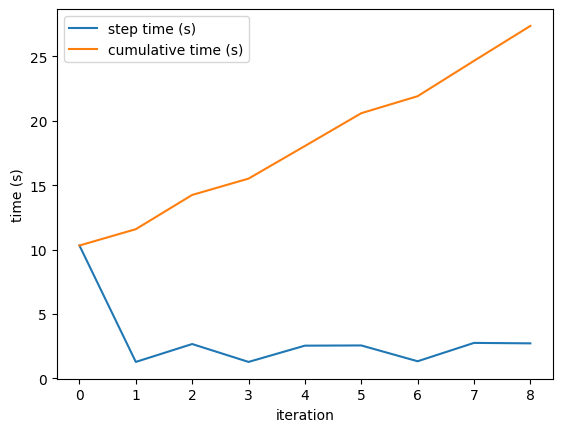

In [59]:
plot_time_stat(heston_stat)

In [48]:
result

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 530552280.8656082
             x: [ 7.931e-02  2.450e+00  5.347e-02  3.471e-01 -8.556e-01
                  2.771e-02]
           nit: 10
          nfev: 21
 final_simplex: (array([[ 7.931e-02,  2.450e+00, ..., -8.556e-01,
                         2.771e-02],
                       [ 8.083e-02,  2.700e+00, ..., -8.133e-01,
                         3.025e-02],
                       ...,
                       [ 9.556e-02,  2.900e+00, ..., -8.356e-01,
                         2.958e-02],
                       [ 9.556e-02,  2.900e+00, ..., -8.356e-01,
                         2.958e-02]]), array([ 5.306e+08,  1.812e+10,  2.934e+11,  3.210e+11,
                        1.559e+12,  5.696e+12,  6.893e+12]))

In [49]:
v0, kappa, theta, sigma, rho, lambd = [param for param in result.x]
print(f"v0={v0}, kappa={kappa}, theta={theta}, sigma={sigma}, rho={rho}, lambda={lambd}")

v0=0.07930555555555524, kappa=2.450000000000001, theta=0.05347222222222206, sigma=0.34708333333333374, rho=-0.8555555555555538, lambda=0.02770833333333335


In [50]:
heston_prices = heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
vol_surface_long['heston_price'] = heston_prices
vol_surface_long

,maturity,strike,price,rate,heston_price,difference
0,-0.276523,34.0,0.0010,0.049457,155.949751,-52.344923
1,-0.257358,34.0,4.8450,0.049457,743.252596,-44.219858
2,-0.238193,34.0,4.9290,0.049457,1418.516903,-41.054350
3,-0.161533,34.0,5.3502,0.049457,-1944.364622,-32.544980
4,-0.065708,34.0,5.4525,0.049457,-88707.637782,-68.899400
...,...,...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467,55.713529,-54.585505
68,0.930869,48.0,1.4838,0.043163,57.034634,-55.499811
69,1.429158,48.0,1.8221,0.041185,59.813516,-57.629294
70,1.927447,48.0,2.2106,0.039868,61.343016,-59.780146


In [51]:
vol_surface_long['difference'] = vol_surface_long['price'] - vol_surface_long['heston_price']
vol_surface_long['difference'].describe()

count        72.000000
mean        855.670179
std       23179.352115
min     -100967.353265
25%         -68.756557
50%         -62.053806
75%         -56.531650
max       88713.090282
Name: difference, dtype: float64

### Apply the Merton Jump Model

In [52]:
S0 =    30  # Replace with real market data
r =     vol_surface_long['rate'].to_numpy(float)
K =     vol_surface_long['strike'].to_numpy(float)
tau =   vol_surface_long['maturity'].to_numpy(float)
P =     vol_surface_long['price'].to_numpy(float)

params = {
    "sigma":    {"x0": 0.2, "lbub": [1e-2, 1]},
    "lambd":    {"x0": 0.1, "lbub": [1e-3, 1]},
    "mu_j":     {"x0": 0,   "lbub": [-1, 1]},
    "sigma_j":  {"x0": 0.1, "lbub": [1e-2, 1]},
}

x0 =    [param["x0"]    for param in params.values()]
bnds =  [param["lbub"]  for param in params.values()]

In [53]:
def SqErr_merton(x):
    sigma, lambd, mu_j, sigma_j = x
    return np.sum((P - merton_price_rec(S0, K, sigma, lambd, mu_j, sigma_j, tau, r))**2 / len(P))

In [61]:
start = time.time()
prev = time.time()
iteration = 0
stat = merton_stat = []

result = minimize(SqErr_merton, x0, bounds=bnds, method=method, options={'maxiter': max_iter}, callback=callback)

#iterations	step time (s)	total time (s)
0		4.273		4.273
1		0.578		4.851
2		0.578		5.429
3		1.152		6.581
4		1.152		7.733
5		0.639		8.372
6		1.194		9.567
7		1.364		10.932
8		0.701		11.633


In [63]:
result

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 27.997673177839673
             x: [ 5.868e-02  1.047e-01  5.489e-04  1.213e-01]
           nit: 10
          nfev: 19
 final_simplex: (array([[ 5.868e-02,  1.047e-01,  5.489e-04,  1.213e-01],
                       [ 5.909e-02,  1.094e-01,  8.142e-04,  1.218e-01],
                       ...,
                       [ 1.409e-01,  1.012e-01,  5.889e-04,  1.094e-01],
                       [ 1.461e-01,  1.061e-01,  3.589e-04,  1.044e-01]]), array([ 2.800e+01,  2.941e+01,  6.762e+09,  2.423e+20,
                        1.436e+22]))

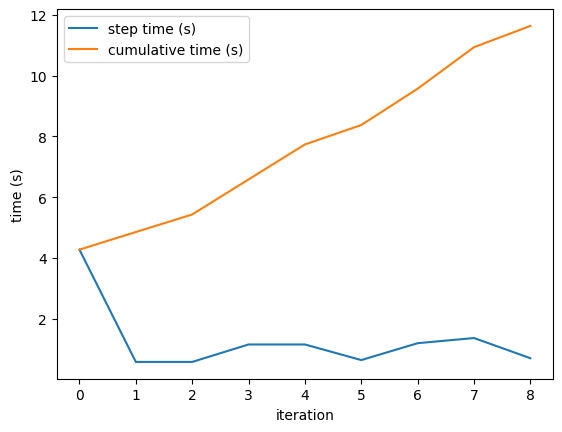

In [78]:
plot_time_stat(merton_stat)

In [65]:
sigma, lambd, mu_j, sigma_j = result.x
print(f"Calibrated parameters: sigma={sigma}, lambd={lambd}, mu_j={mu_j}, sigma_j={sigma_j}")

# --- Part 8: Final Volatility Surface and Comparison ---
merton_prices = merton_price_rec(S0, K, sigma, lambd, mu_j, sigma_j, tau, r)
vol_surface_long['merton_price'] = merton_prices
vol_surface_long['difference'] = vol_surface_long['price'] - vol_surface_long['merton_price']
vol_surface_long['difference'].describe()

Calibrated parameters: sigma=0.05868164062500025, lambd=0.1047149658203127, mu_j=0.0005488586425781249, sigma_j=0.12130432128906254


count    72.000000
mean      3.856507
std       3.648272
min      -5.419716
25%       1.675299
50%       4.094892
75%       6.259453
max      13.217228
Name: difference, dtype: float64

In [66]:
vol_surface_long.describe()

,maturity,strike,price,rate,heston_price,difference,merton_price
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.584303,40.000000,2.972253,0.045743,-852.697926,3.856507,-0.884254
std,0.887791,4.794363,2.264968,0.003923,23179.054411,3.648272,2.931294
min,-0.276523,34.000000,0.000200,0.039040,-88707.637782,-5.419716,-13.216228
25%,-0.180698,36.000000,1.022975,0.042668,57.982876,1.675299,-0.897218
50%,0.308008,39.000000,2.872700,0.046953,66.748704,4.094892,-0.354486
75%,1.055441,44.000000,4.866000,0.049457,75.806955,6.259453,-0.110770
max,2.425736,48.000000,7.215400,0.049457,100967.481665,13.217228,5.420716


<Axes: >

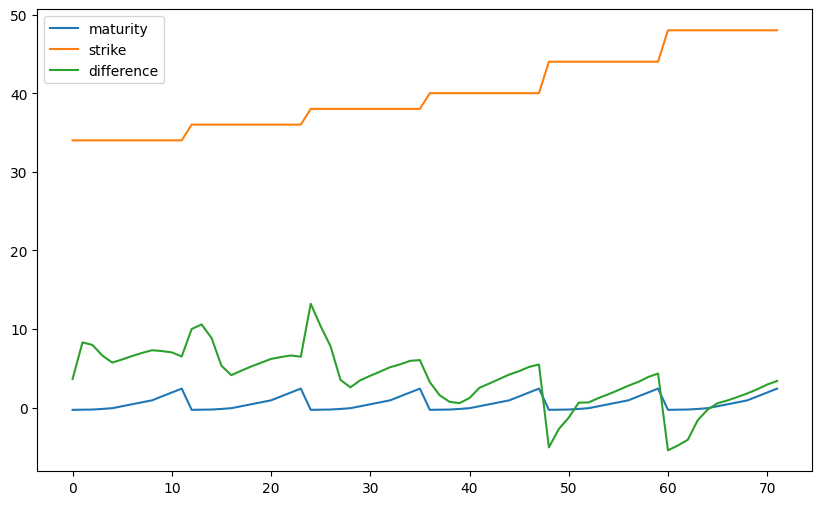

In [67]:
vol_surface_long[['maturity', 'strike', 'difference']].plot.line(figsize=(10, 6))

### Kou Model

In [71]:
S0 =    30  # Replace with real market data
r =     vol_surface_long['rate'].to_numpy(float)
K =     vol_surface_long['strike'].to_numpy(float)
tau =   vol_surface_long['maturity'].to_numpy(float)
P =     vol_surface_long['price'].to_numpy(float)

x0 =    [param["x0"]    for param in params.values()]
bnds =  [param["lbub"]  for param in params.values()]

params = {
    "sigma":    {"x0": 0.2, "lbub": [1e-2, 1]},
    "lambd":    {"x0": 0.1, "lbub": [1e-3, 1]},
    "p":        {"x0": 0.5, "lbub": [0.01, 0.99]},
    "eta1":     {"x0": 10, "lbub": [1, 20]},
    "eta2":     {"x0": 10, "lbub": [1, 20]},
}

In [72]:
def SqErr(x):
    sigma, lambd, p, eta1, eta2 = x
    return np.sum((P - kou_price_rec(S0, K, sigma, lambd, p, eta1, eta2, tau, r))**2 / len(P))

In [73]:
iteration = 0
start = time.time()
prev = time.time()
stat = kou_stat = []

result = minimize(SqErr, x0, bounds=bnds, method=method, options={'maxiter': max_iter}, callback=callback)

#iterations	step time (s)	total time (s)
0		5.001		5.001
1		0.628		5.629
2		0.609		6.237
3		0.612		6.85
4		1.244		8.094
5		1.233		9.327
6		0.609		9.936
7		1.208		11.144
8		0.62		11.765


In [74]:
result

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 410200418731143.06
             x: [ 1.226e-01  1.029e-01  5.651e-01  1.068e+01  1.158e+01]
           nit: 10
          nfev: 19
 final_simplex: (array([[ 1.226e-01,  1.029e-01, ...,  1.068e+01,
                         1.158e+01],
                       [ 1.245e-01,  1.033e-01, ...,  1.044e+01,
                         1.141e+01],
                       ...,
                       [ 1.671e-01,  9.906e-02, ...,  1.002e+01,
                         1.132e+01],
                       [ 1.800e-01,  1.030e-01, ...,  1.030e+01,
                         1.030e+01]]), array([ 4.102e+14,  1.454e+15,  3.821e+22,  2.337e+25,
                        1.057e+30,  2.536e+35]))

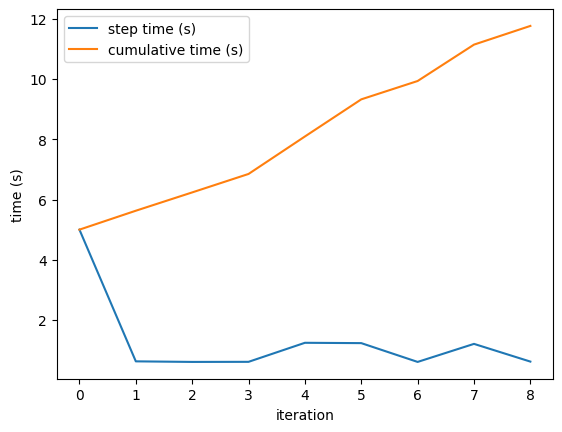

In [75]:
plot_time_stat(kou_stat)

In [76]:
sigma, lambd, p, eta1, eta2 = result.x
print(f"Calibrated parameters: sigma={sigma}, lambd={lambd}, p={p}, eta1={eta1}, eta2={eta2}")

# --- Step 8: Final Volatility Surface and Comparison ---
kou_prices = kou_price_rec(S0, K, sigma, lambd, p, eta1, eta2, tau, r)
vol_surface_long['kou_price'] = kou_prices
vol_surface_long['difference'] = vol_surface_long['price'] - vol_surface_long['kou_price']
vol_surface_long

Calibrated parameters: sigma=0.12262604799999999, lambd=0.1029321728, p=0.5651143040000008, eta1=10.675758079999994, eta2=11.582958080000012


,maturity,strike,price,rate,heston_price,difference,merton_price,kou_price
0,-0.276523,34.0,0.0010,0.049457,155.949751,1.146016e+05,-3.637779,-1.146016e+05
1,-0.257358,34.0,4.8450,0.049457,743.252596,3.038245e+06,-3.454299,-3.038240e+06
2,-0.238193,34.0,4.9290,0.049457,1418.516903,1.427899e+06,-3.048845,-1.427894e+06
3,-0.161533,34.0,5.3502,0.049457,-1944.364622,1.273893e+04,-1.276362,-1.273358e+04
4,-0.065708,34.0,5.4525,0.049457,-88707.637782,1.976376e+01,-0.281234,-1.431126e+01
...,...,...,...,...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467,55.713529,1.472484e+00,-0.243782,-3.595838e-01
68,0.930869,48.0,1.4838,0.043163,57.034634,1.973461e+00,-0.331306,-4.896610e-01
69,1.429158,48.0,1.8221,0.041185,59.813516,2.570327e+00,-0.519725,-7.482271e-01
70,1.927447,48.0,2.2106,0.039868,61.343016,3.183281e+00,-0.728175,-9.726810e-01


In [77]:
vol_surface_long.describe()

,maturity,strike,price,rate,heston_price,difference,merton_price,kou_price
count,72.000000,72.000000,72.000000,72.000000,72.000000,7.200000e+01,72.000000,7.200000e+01
mean,0.584303,40.000000,2.972253,0.045743,-852.697926,2.823515e+06,-0.884254,-2.823512e+06
std,0.887791,4.794363,2.264968,0.003923,23179.054411,2.019637e+07,2.931294,2.019637e+07
min,-0.276523,34.000000,0.000200,0.039040,-88707.637782,-7.531851e+07,-13.216228,-1.191772e+08
25%,-0.180698,36.000000,1.022975,0.042668,57.982876,2.566962e+00,-0.897218,-1.072099e+01
50%,0.308008,39.000000,2.872700,0.046953,66.748704,4.792038e+00,-0.354486,-3.404097e-01
75%,1.055441,44.000000,4.866000,0.049457,75.806955,1.207925e+01,-0.110770,8.065407e-02
max,2.425736,48.000000,7.215400,0.049457,100967.481665,1.191772e+08,5.420716,7.531851e+07
